In [44]:
import numpy as np
import Hawkes as hk
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import scipy.integrate as si

(134,)
[ 82.6431088   82.70453101  83.18023443  83.23562991  83.28382892
  83.44223713  83.47981936  83.49132868  83.49663423  83.60751983
  83.66631328  83.69911111  83.70645516  83.75377091  83.77946967
  83.79263704  83.97690001  84.12845946  84.14913638  84.18722319
  84.2499476   84.27384873  84.40832827  84.64914866  85.99324336
  86.44626854  86.53040029  86.57138405  86.59505587  86.62149537
  86.67191629  86.68404229  86.75106377  86.95056616  87.01366049
  87.07007627  87.10995878  87.16575424  87.19204441  87.21747431
  87.2254729   87.31423881  87.3296893   87.35216858  87.36234057
  87.39527319  87.44329499  87.48152157  87.52215177  87.53712021
  87.54079509  87.5476426   87.62616973  87.70595666  87.717482
  87.8476396   87.92700433  88.02987346  88.3740847   88.45244928
 116.52638421 117.02593804 125.52065045 125.69348315 125.71281616
 125.77697048 125.82015262 125.86123684 125.90129183 125.90885635
 125.9245755  125.96982673 125.97174549 125.97478106 126.06826133
 126.

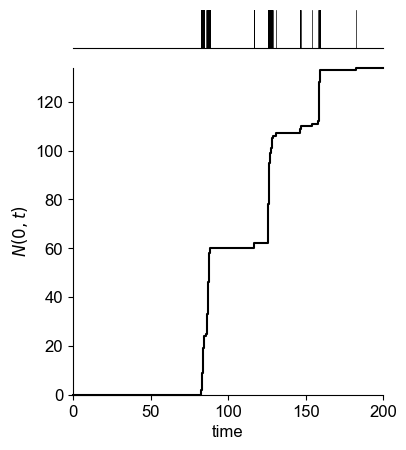

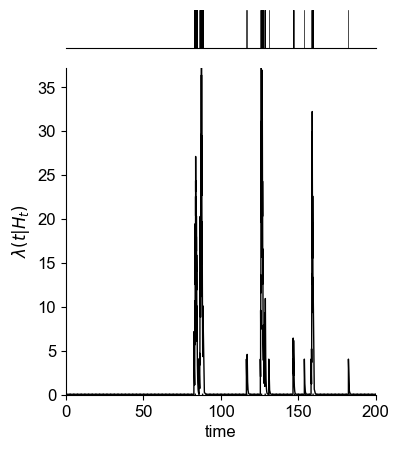

In [36]:
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'mu':0.05, 'alpha':1.0, 'beta':4.0}
model.set_parameter(para)
itv = [0,200] # the observation interval
T = model.simulate(itv)
model.plot_N()
model.plot_l()
print(np.shape(T))
print(T)


c:\Users\zozow\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[ 85.83837326]
 [157.29591712]
 [126.27488493]
 [182.3499827 ]]


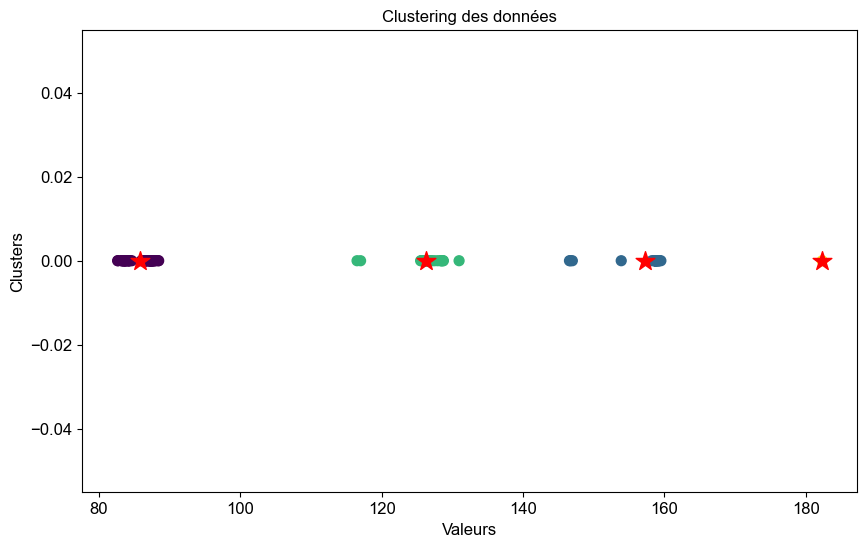

In [42]:
T = T.reshape(-1,1)
num_clusters = 4  # Vous pouvez ajuster ce nombre en fonction de vos besoins
kmeans = KMeans(n_clusters=num_clusters)

# Effectuer le clustering
kmeans.fit(T)

# Obtenir les étiquettes des clusters et les centres des clusters
labels = kmeans.labels_
centers = kmeans.cluster_centers_
print(centers)
# Tracer les données avec les clusters
plt.figure(figsize=(10, 6))
plt.scatter(T, np.zeros_like(T), c=labels, cmap='viridis', s=50)
plt.scatter(centers, np.zeros_like(centers), marker='*', c='red', s=200)
plt.title('Clustering des données')
plt.xlabel('Valeurs')
plt.ylabel('Clusters')
plt.show()

[  0.           7.14285714  14.28571429  21.42857143  28.57142857
  35.71428571  42.85714286  50.          57.14285714  64.28571429
  71.42857143  78.57142857  85.71428571  92.85714286 100.
 107.14285714 114.28571429 121.42857143 128.57142857 135.71428571
 142.85714286 150.         157.14285714 164.28571429 171.42857143
 178.57142857 185.71428571 192.85714286 200.        ]


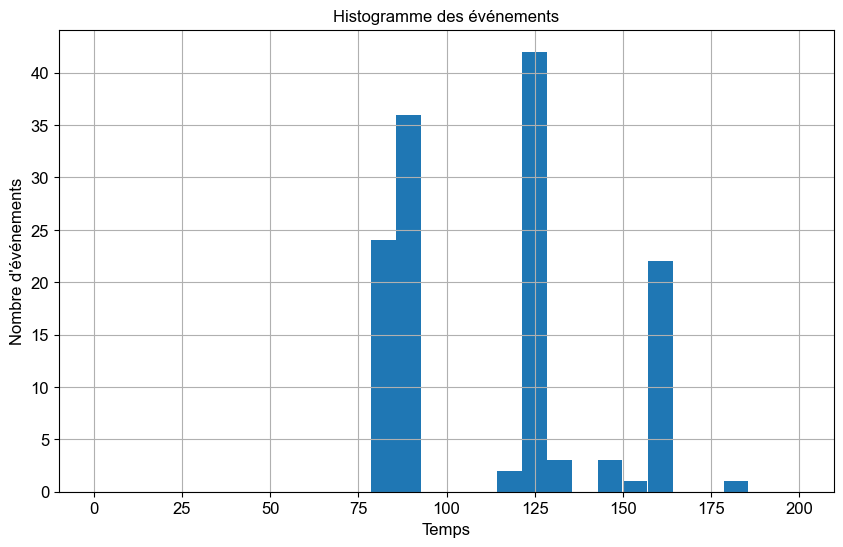

In [37]:
interval_length = 7  # Longueur de l'intervalle en unités de temps
num_intervals = int((itv[1] - itv[0]) / interval_length)
intervals = np.linspace(itv[0], itv[1], num_intervals + 1)
print(intervals)
# Compter le nombre d'événements dans chaque intervalle
event_counts, _ = np.histogram(T, bins=intervals)

# Tracer l'histogramme des événements
plt.figure(figsize=(10, 6))
plt.bar(intervals[:-1], event_counts, width=interval_length, align='edge')
plt.title('Histogramme des événements')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.grid(True)
plt.show()

In [14]:
model = Sequential()
model.add(Dense(150, activation='relu', kernel_initializer = tf.initializers.RandomUniform(minval=0, maxval=0.5), input_shape=(1,)))
model.add(Dense(1, activation=lambda x: tf.exp(x)))
model.compile(optimizer='adam', loss='mse')

para = {'mu':0.05, 'alpha':1.0, 'beta':4.0}

In [15]:
def phi(x):
    result = para['alpha']*np.exp(- para['beta']*x)
    return result

In [16]:
X =  np.array([[x] for x in np.arange(0, 5, 0.01)]).astype(np.float32)
y = phi(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

model.fit(X_train, y_train, epochs=200, batch_size=50)

Epoch 1/200

8/8 [==============================] - 1s 4ms/step - loss: 0.9793
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1796
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0886
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0496
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0427
Epoch 7/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 8/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0349
Epoch 9/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 10/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0298
Epoch 11/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 12/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 13/200
8/8 [==============================] - 0s 3ms/s

4/4 [==============================] - 0s 3ms/step


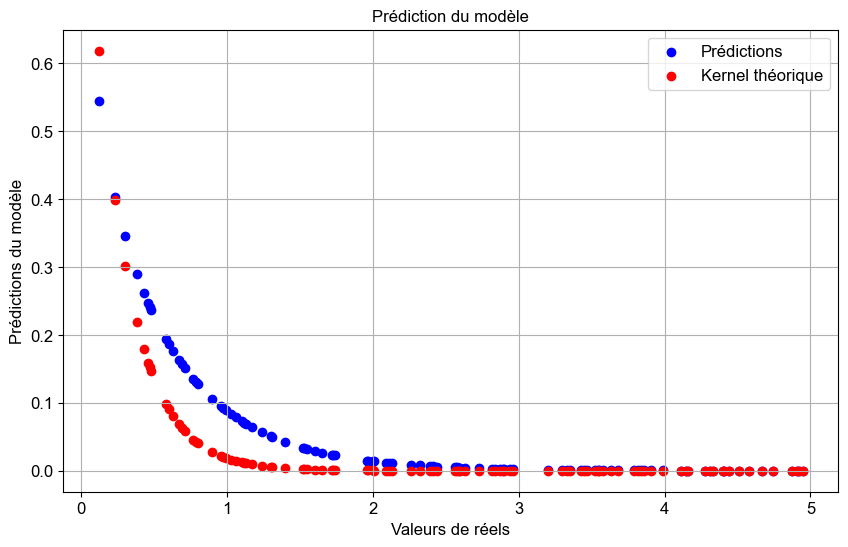

In [17]:
y_true = phi(X_test)  # Les vraies valeurs
y_pred = model.predict(X_test)  # Les prédictions de votre modèle
# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, color='blue', label='Prédictions')
plt.scatter(X_test, y_true, color='red', label='Kernel théorique')
plt.title('Prédiction du modèle')
plt.xlabel('Valeurs de réels')
plt.ylabel('Prédictions du modèle')
plt.legend()
plt.grid(True)
plt.show()

(0.0, 0.2)

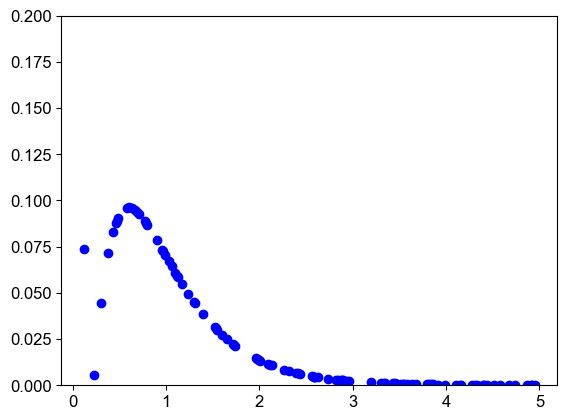

In [18]:
erreur = abs(y_true - y_pred)
plt.scatter(X_test, erreur, color='blue', label='Erreurs')
plt.ylim(0,0.2)

In [43]:
def lbda(t):
    mu = para['mu']
    s=0
    for i in range(len(centers)):
        s += phi(t-centers[i])
    return (mu + s)


In [49]:
def neg_log_lh(para):
    s = 0
    for t in centers:
        s += np.log10(lbda(t))
    I = si.quad(lbda,0,200)[0]
    return -(s-I)

In [53]:
def gradient_neg_log_lh(para, centers, lbda):
    gradient = {}
    epsilon = 1e-5  # Petit epsilon pour la différence finie
    
    for key, value in para.items():
        para_plus_epsilon = para.copy()
        para_plus_epsilon[key] += epsilon
        
        para_minus_epsilon = para.copy()
        para_minus_epsilon[key] -= epsilon
        
        gradient[key] = (neg_log_lh(para_plus_epsilon) - neg_log_lh(para_minus_epsilon)) / (2 * epsilon)
    
    return gradient

In [58]:
# Paramètres de l'algorithme
learning_rate = 0.1
num_iterations = 30
para_initial = para.copy()  # Point de départ arbitraire

def stochastic_gradient_descent(centers, lbda):
    para = para_initial.copy()
    historique_couts = []
    
    for _ in range(num_iterations):
        # Sélectionner aléatoirement un échantillon ou une observation (ici, nous avons un seul échantillon)
        # Mettre à jour le gradient pour chaque paramètre du dictionnaire
        gradient = gradient_neg_log_lh(para, centers, lbda)
        
        # Mettre à jour les paramètres en utilisant le gradient
        for key in para:
            para[key] -= learning_rate * gradient[key]
        
        # Calculer le coût et l'ajouter à l'historique
        cout = neg_log_lh(para)
        historique_couts.append(cout)
    
    return para, historique_couts

C:\Users\zozow\AppData\Local\Temp\ipykernel_35424\1409293966.py:2: RuntimeWarning: overflow encountered in exp
  result = para['alpha']*np.exp(- para['beta']*x)
C:\Users\zozow\AppData\Local\Temp\ipykernel_35424\630770048.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = si.quad(lbda,0,200)[0]


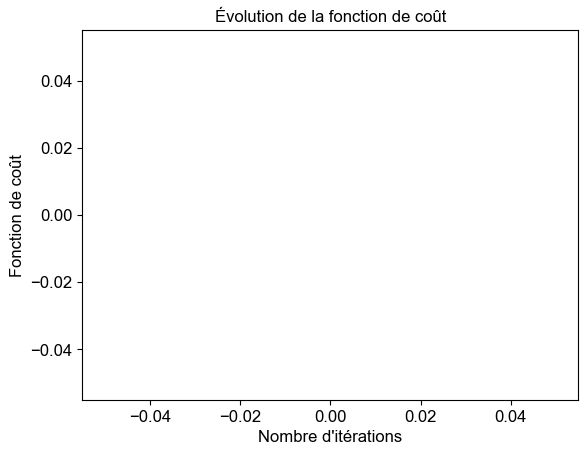

In [60]:
# Affichage de l'évolution de la fonction de coût
plt.plot(range(num_iterations), stochastic_gradient_descent(centers,lbda)[1])
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Fonction de coût')
plt.title('Évolution de la fonction de coût')
plt.show()